In [1]:
import spot
import spot.ltsmin
# The following line causes the notebook to exit with 77 if divine is not 
# installed, therefore skipping this test in the test suite.
spot.ltsmin.require('divine')
# This notebook also tests the limitation of the number of states in the GraphViz output
spot.setup(max_states=10)

There are two ways to load a DiVinE model: from a file or from a cell.   

Loading from a file
-------------------

We will first start with the file version, however because this notebook should also be a self-contained test case, we start by writing a model into a file.

In [2]:
!rm -f test1.dve

In [3]:
%%file test1.dve
int a = 0, b = 0;

process P {
 state x;
 init x;

 trans
   x -> x { guard a < 3 && b < 3; effect a = a + 1; },
   x -> x { guard a < 3 && b < 3; effect b = b + 1; };
}

process Q {
  state wait, work;
  init wait;
  trans
    wait -> work { guard b > 1; },
    work -> wait { guard a > 1; };
}

system async;

Writing test1.dve


The `spot.ltsmin.load` function compiles the model using the `ltlmin` interface and load it.  This should work with DiVinE models if `divine --LTSmin` works, and with Promela models if `spins` is installed.

In [4]:
m = spot.ltsmin.load('test1.dve')

Compiling the model creates all several kinds of files.  The `test1.dve` file is converted into a C++ source code `test1.dve.cpp` which is then compiled into a shared library `test1.dve2c`.  Becauce `spot.ltsmin.load()` has already loaded this shared library, all those files can be erased.  If you do not erase the files, `spot.ltsmin.load()` will use the timestamps to decide whether the library should be recompiled or not everytime you load the library.

For editing and loading DVE file from a notebook, it is a better to use the `%%dve` as shown next.

In [5]:
!rm -f test1.dve test1.dve.cpp test1.dve2C

Loading from a notebook cell
----------------------------

The `%%dve` cell magic implements all of the above steps (saving the model into a temporary file, compiling it, loading it, erasing the temporary files).  The variable name that should receive the model (here `m`) should be indicated on the first line, after `%dve`.

In [6]:
%%dve m
int a = 0, b = 0;

process P {
 state x;
 init x;

 trans
   x -> x { guard a < 3 && b < 3; effect a = a + 1; },
   x -> x { guard a < 3 && b < 3; effect b = b + 1; };
}

process Q {
  state wait, work;
  init wait;
  trans
    wait -> work { guard b > 1; },
    work -> wait { guard a > 1; };
}

system async;

Working with an ltsmin model
----------------------------

Printing an ltsmin model shows some information about the variables it contains and their types, however the `info()` methods provide the data in a map that is easier to work with.

In [7]:
m

ltsmin model with the following variables:
  a: int
  b: int
  P: ['x']
  Q: ['wait', 'work']

In [8]:
sorted(m.info().items())

[('state_size', 4),
 ('types', [('int', []), ('P', ['x']), ('Q', ['wait', 'work'])]),
 ('variables', [('a', 0), ('b', 0), ('P', 1), ('Q', 2)])]

To obtain a Kripke structure, call `kripke` and supply a list of atomic propositions to observe in the model.

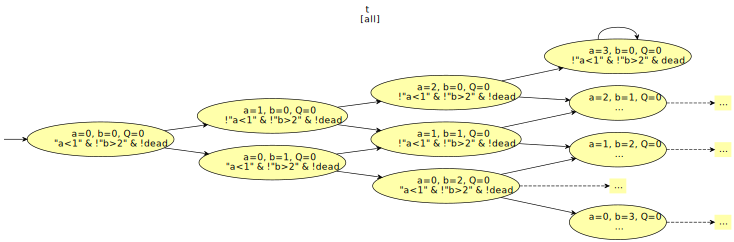

In [9]:
k = m.kripke(["a<1", "b>2"])
k

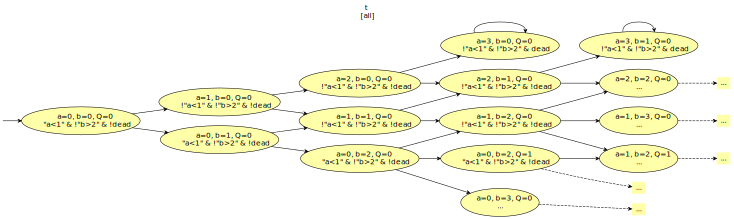

In [10]:
k.show('.<15')

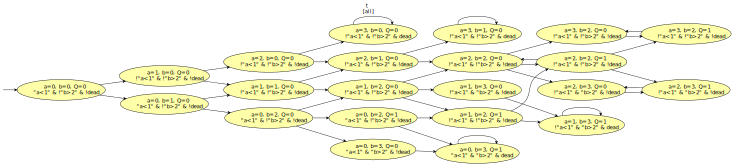

In [11]:
k.show('.<0')  # unlimited output

If we have an LTL proposition to check, we can convert it into an automaton using `spot.translate()`, and synchronize that automaton with the Kripke structure using `spot.otf_product()`.  This `otf_product()` function returns product automaton that builds itself on-the-fly, as needed by whatever algorithm "consumes" it (here the display routine). 

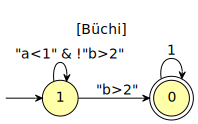

In [12]:
a = spot.translate('"a<1" U "b>2"'); a

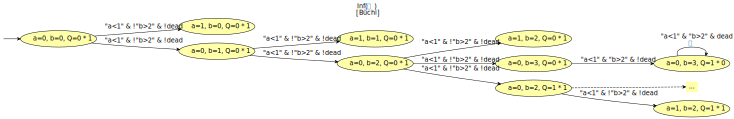

In [13]:
spot.otf_product(k, a)

If we want to create a `model_check` function that takes a model and formula, we need to get the list of atomic propositions used in the formula using `atomic_prop_collect()`.  This returns an `atomic_prop_set`:

In [14]:
a = spot.atomic_prop_collect(spot.formula('"a < 2" W "b == 1"')); a

spot.atomic_prop_set([spot.formula("\"a < 2\""), spot.formula("\"b == 1\"")])

In [15]:
def model_check(f, m):
    nf = spot.formula.Not(f)
    ss = m.kripke(spot.atomic_prop_collect(nf))
    return spot.otf_product(ss, nf.translate()).is_empty() 

In [16]:
model_check('"a<1" R "b > 1"', m)

False

Instead of `otf_product(x, y).is_empty()` we prefer to call `!x.intersects(y)`.  There is also `x.intersecting_run(y)` that can be used to return a counterexample.

In [17]:
def model_debug(f, m):
    nf = spot.formula.Not(f)
    ss = m.kripke(spot.atomic_prop_collect(nf))
    return ss.intersecting_run(nf.translate())

In [18]:
run = model_debug('"a<1" R "b > 1"', m); print(run)

Prefix:
  a=0, b=0, Q=0
  |  "a<1" & !"b > 1" & !dead
  a=1, b=0, Q=0
  |  !"a<1" & !"b > 1" & !dead
  a=2, b=0, Q=0
  |  !"a<1" & !"b > 1" & !dead
Cycle:
  a=3, b=0, Q=0
  |  !"a<1" & !"b > 1" & dead



This accepting run can be represented as an automaton (the `True` argument requires the state names to be preserved).  This can be more readable.

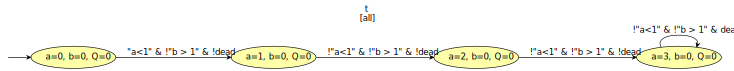

In [19]:
run.as_twa(True)

# Saving Kripke structures to some file

For experiments, it is sometime useful to save a Kripke structure in the HOA format.  The HOA printer will automatically use `state-labels` for Kripke structures.

In [20]:
string = k.to_str('hoa')
print(string)

HOA: v1
States: 22
Start: 0
AP: 3 "a<1" "b>2" "dead"
acc-name: all
Acceptance: 0 t
properties: state-labels explicit-labels state-acc
--BODY--
State: [0&!1&!2] 0 "a=0, b=0, Q=0"
1 2
State: [!0&!1&!2] 1 "a=1, b=0, Q=0"
3 4
State: [0&!1&!2] 2 "a=0, b=1, Q=0"
4 5
State: [!0&!1&!2] 3 "a=2, b=0, Q=0"
6 7
State: [!0&!1&!2] 4 "a=1, b=1, Q=0"
7 8
State: [0&!1&!2] 5 "a=0, b=2, Q=0"
8 9 10
State: [!0&!1&2] 6 "a=3, b=0, Q=0"
6
State: [!0&!1&!2] 7 "a=2, b=1, Q=0"
11 12
State: [!0&!1&!2] 8 "a=1, b=2, Q=0"
12 13 14
State: [0&1&!2] 9 "a=0, b=3, Q=0"
15
State: [0&!1&!2] 10 "a=0, b=2, Q=1"
14 15
State: [!0&!1&2] 11 "a=3, b=1, Q=0"
11
State: [!0&!1&!2] 12 "a=2, b=2, Q=0"
16 17 18
State: [!0&1&!2] 13 "a=1, b=3, Q=0"
19
State: [!0&!1&!2] 14 "a=1, b=2, Q=1"
18 19
State: [0&1&2] 15 "a=0, b=3, Q=1"
15
State: [!0&!1&!2] 16 "a=3, b=2, Q=0"
20
State: [!0&1&!2] 17 "a=2, b=3, Q=0"
21
State: [!0&!1&!2] 18 "a=2, b=2, Q=1"
20 21 12
State: [!0&1&2] 19 "a=1, b=3, Q=1"
19
State: [!0&!1&!2] 20 "a=3, b=2, Q=1"
16
State: 

You can load this as a Kripke structure by passing the `want_kripke` option to `spot.automaton()`.  The type `kripke_graph` stores the Kripke structure explicitely (like a `twa_graph` stores an automaton explicitely), so you may want to avoid it for very large modelsand use it only for development.

<class 'spot.impl.kripke_graph'>


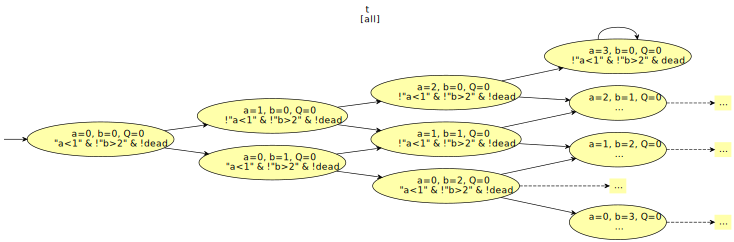

In [21]:
k2 = spot.automaton(string, want_kripke=True)
print(type(k2))
k2